# A Look Into Autoencoders

In [1]:
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
import matplotlib.pyplot as plt
from scipy import ndimage, misc
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D, Lambda, Activation
from keras.losses import mse
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


## 1. Training and Testing Set

### 1.1 Initial dataset

In [2]:
# parameters
l = 32
size = 1000

x1 = []
def create_slope(angle):
    x = np.zeros((127, 127))
    center = 127//2
    x[center:].fill(1)
    x = ndimage.rotate(x, angle)
    center2 = x.shape[0]//2
    x = x[center2-l//2:center2+l//2, center2-l//2:center2+l//2]
    return x

for i in range(size):
    angle = 360*i/size
    x1.append(create_slope(angle))

x1 = np.asarray(x1)
x1.shape

(1000, 32, 32)

### 1.2 simplified dataset

In [13]:
x2 = []
dataset_size = 2
l = 2

d = np.zeros((2, 2))
d[1,:].fill(1)
x2.append(d)
b = np.zeros((2, 2))
b[:,0].fill(1)
x2.append(b)
a = np.zeros((2, 2))
a[0,:].fill(1)
x2.append(a)
c = np.zeros((2, 2))
c[:,1].fill(1)
x2.append(c)

x2 = np.asarray(x2)
x2.shape

(4, 2, 2)

In [4]:
# Optional: split in training and testing
x = np.random.permutation(x)
x1 = x[500:]  #training
x2 = x[0:500] #testing
len(x1), len(x2)

NameError: name 'x' is not defined

### 1.3 show dataset

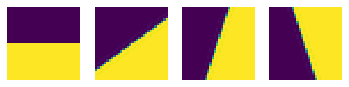

NameError: name 'x2' is not defined

In [3]:
def plot_dataset(x, a):    
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(x[i*a], vmin=0, vmax=1)

for i in range(4):
    plot_dataset(x1, 100)
plt.show()

for i in range(4):
    plot_dataset(x2, 1)
plt.show()

## 2. Neural Network

In [4]:
def autoencoder_A1(a, b):
    input_img = Input(shape=(dim,))
    encoded = Dense(a, activation='relu')(input_img)
    encoded = Dense(b)(encoded)
    decoded = Dense(a, activation='relu')(encoded)
    decoded = Dense(dim, activation='sigmoid')(decoded)
    model = Model(input_img, decoded)
    model.compile(optimizer='adadelta', loss='mse')
    return model


def sampling(x):
    a, b = x                                    # a is the mean, b is ln(sigma)
    batch = K.shape(a)[0]
    dim = K.int_shape(a)[1]
    epsilon = K.random_normal(shape=(batch, dim), mean=0, stddev=1)
    return a + K.exp(b) * epsilon               # if a and b = 0, it is a normal distribution N(0, 1)

def autoencoder_A2(c, k):
    inputs = Input(shape=(dim, ))
    x = Dense(c, activation='relu')(inputs)
    a = Dense(k)(x)                             # the mean
    b = Dense(k)(x)                             # ln(sigma)
    z = Lambda(sampling, output_shape=(k,))([a, b])
    x = Dense(c, activation='relu')(z)
    outputs = Dense(dim, activation='sigmoid')(x)
    vae = Model(inputs, outputs)

    # loss function:
    r_loss = mse(inputs, outputs)*dim            # '*dim' because we have a sum and not a mean in two lines
    kl_loss = 1 + b - K.square(a) - K.exp(b)     # this loss is minimized when a and b = 0
    kl_loss = K.sum(kl_loss, axis=-1)*(-0.5)     # *-0.5 to have a positive function
    vae_loss = K.mean(r_loss + kl_loss)
    vae.add_loss(vae_loss)

    vae.compile(optimizer='adam')
    return vae

# Results Using A1

In [16]:
#use_postprocessing = False

def plot_results(model, x, nr, use_postprocessing=False):
    n = x.shape[1]
    if len(model.input_shape)==2:
        output = model.predict(x.reshape(len(x), dim))
    else:
        output = model.predict(x.reshape(len(x), 28, 28, 1))
    print(output)
    if use_postprocessing:
        output = np.log(output/(1-output))
        output = np.heaviside(output, 0.5)
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.axis('off')
#        plt.imshow(x[nr*i].reshape(n, n), vmin=0, vmax=1)
#        plt.subplot(2, 4, i+5)
#        plt.axis('off')
        plt.imshow(output[nr*i].reshape(n, n), vmin=0, vmax=1)
    plt.show()

In [17]:
def train(model, x):
    if len(model.input_shape)==2:
        model.fit(x.reshape(len(x), dim), x.reshape(len(x), dim), epochs = 2000)
    else:
        model.fit(x.reshape(len(x), n, n, 1), x.reshape(len(x), n, n, 1), epochs = 2000)
    return model

### Simplified dataset

In [139]:
dim = x2.shape[1]*x2.shape[1]
model1 = autoencoder_A1(2, 1)
#model2 = autoencoder_A2(2, 1)

In [140]:
# initial weight values
W = model1.layers[1].get_weights()
W

[array([[-0.943727  ,  0.1273725 ],
        [ 0.48652363, -0.7860389 ],
        [-0.03642011, -0.5796528 ],
        [-0.3608787 ,  0.13464308]], dtype=float32),
 array([0., 0.], dtype=float32)]

In [141]:
model1 = train(model1, x2)

Epoch 1/2000
4/4 [==============================] - 1s 243ms/step - loss: 0.2500
Epoch 2/2000
4/4 [==============================] - 0s 913us/step - loss: 0.2500
Epoch 3/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 4/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 5/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 6/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 7/2000
4/4 [==============================] - 0s 946us/step - loss: 0.2500
Epoch 8/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 9/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 10/2000
4/4 [==============================] - 0s 919us/step - loss: 0.2500
Epoch 11/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 12/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 13/2000
4/4 [======================

Epoch 103/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 104/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 105/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 106/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 107/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.2500
Epoch 108/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 109/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 110/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 111/2000
4/4 [==============================] - 0s 831us/step - loss: 0.2500
Epoch 112/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 113/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 114/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 115/2000
4/4 [======

Epoch 204/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 205/2000
4/4 [==============================] - 0s 886us/step - loss: 0.2500
Epoch 206/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 207/2000
4/4 [==============================] - 0s 858us/step - loss: 0.2500
Epoch 208/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 209/2000
4/4 [==============================] - 0s 999us/step - loss: 0.2500
Epoch 210/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 211/2000
4/4 [==============================] - 0s 994us/step - loss: 0.2500
Epoch 212/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 213/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 214/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 215/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 216/2000
4/4 [

Epoch 305/2000
4/4 [==============================] - 0s 781us/step - loss: 0.2500
Epoch 306/2000
4/4 [==============================] - 0s 676us/step - loss: 0.2500
Epoch 307/2000
4/4 [==============================] - 0s 687us/step - loss: 0.2500
Epoch 308/2000
4/4 [==============================] - 0s 723us/step - loss: 0.2500
Epoch 309/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 310/2000
4/4 [==============================] - 0s 801us/step - loss: 0.2500
Epoch 311/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 312/2000
4/4 [==============================] - 0s 980us/step - loss: 0.2500
Epoch 313/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 314/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 315/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 316/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 317/2000
4

4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 406/2000
4/4 [==============================] - 0s 9ms/step - loss: 0.2500
Epoch 407/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 408/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 409/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 410/2000
4/4 [==============================] - 0s 883us/step - loss: 0.2500
Epoch 411/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 412/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 413/2000
4/4 [==============================] - 0s 860us/step - loss: 0.2500
Epoch 414/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 415/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 416/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 417/2000


KeyboardInterrupt: 

[[0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5]]


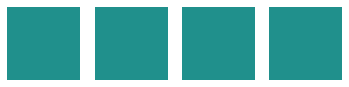

In [142]:
plot_results(model1, x2, 1)

In [148]:
# weights after training
W = model1.layers[3].get_weights()
W

[array([[-0.70958567, -0.6031662 ]], dtype=float32),
 array([0., 0.], dtype=float32)]

In [147]:
get2 = K.function([model1.layers[0].input], [model1.layers[3].output])
out = get2([x2.reshape(len(x2), dim)])
out

[array([[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [-0., -0.]], dtype=float32)]

In [231]:
#model1.save('opt')
#model1.save('subopt1') # 1 coppia
#model1.save('subopt2') # 2 coppie
#model1.save('subopt4') # tutto grigio
#model1.save('subopt5') # 1 tripla


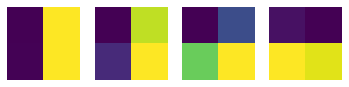

In [247]:
# plot bottleneck near threshold
nr = 4
z = np.arange(nr).reshape(nr, 1)-3
z = z/2
postprocessing = False

get2 = K.function([model1.layers[3].input], [model1.layers[4].output])
out = get2([z])[0]
if postprocessing:
    out = np.log(out/(1-out))
    out = np.heaviside(out, 0.5)
for i in range(nr):
    plt.subplot(1, nr, i+1)
    plt.imshow(out[i].reshape(2, 2))
    plt.axis('off')
plt.show()

### Results on initial dataset

In [41]:
dim = x1.shape[1]*x1.shape[1]
model2 = autoencoder_A1(2, 1)

In [ ]:
model2 = train(model2, x1)

In [44]:
model2 = keras.models.load_model('model2')

[[0.17248887 0.16911304 0.16625094 ... 0.84196943 0.839007   0.8355879 ]
 [0.17614537 0.1723707  0.16914988 ... 0.83968484 0.83632433 0.8324793 ]
 [0.1717296  0.16843605 0.16564795 ... 0.8424452  0.83956516 0.83623403]
 ...
 [0.17367575 0.17017093 0.16719276 ... 0.8412266  0.83813536 0.8345784 ]
 [0.17328379 0.16982165 0.1668818  ... 0.8414718  0.83842313 0.8349117 ]
 [0.17707673 0.1731998  0.169887   ... 0.8391047  0.8356424  0.83168817]]


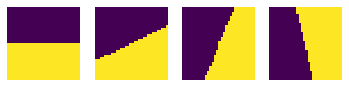

In [45]:
use_postprocessing = True
plot_results(model2, x1, 100, use_postprocessing) 

In [48]:
# weights after training
W = model2.layers[4].get_weights()
print(W)

[array([[ 0.02394504,  0.02168607,  0.01957623, ..., -0.016089  ,
        -0.01859465, -0.02116761],
       [ 0.11900373,  0.12651491,  0.13532722, ..., -0.12610148,
        -0.11793056, -0.11074195]], dtype=float32), array([-1.798995 , -1.8010479, -1.8012105, ...,  1.8281034,  1.8301691,
        1.8298818], dtype=float32)]


# Results Using A2

In [5]:
### Initial dataset

In [6]:
dim = x1.shape[1]*x1.shape[1]
model3 = autoencoder_A2(2, 1)

Instructions for updating:
Colocations handled automatically by placer.


/home/fabrizio/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_5 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_5.
  'be expecting any data to be passed to {0}.'.format(name))


In [53]:
model3.fit(x1.reshape(len(x1), dim), epochs = 200000)

Instructions for updating:
Use tf.cast instead.
Epoch 1/200000
1000/1000 [==============================] - 1s 782us/step - loss: 22.4218
Epoch 2/200000
1000/1000 [==============================] - 0s 181us/step - loss: 15.3417
Epoch 3/200000
1000/1000 [==============================] - 0s 197us/step - loss: 14.8566
Epoch 4/200000
1000/1000 [==============================] - 0s 189us/step - loss: 15.3832
Epoch 5/200000
1000/1000 [==============================] - 0s 190us/step - loss: 14.8419
Epoch 6/200000
1000/1000 [==============================] - 0s 185us/step - loss: 14.5882
Epoch 7/200000
1000/1000 [==============================] - 0s 193us/step - loss: 14.7221
Epoch 8/200000
1000/1000 [==============================] - 0s 194us/step - loss: 14.7322
Epoch 9/200000
1000/1000 [==============================] - 0s 200us/step - loss: 15.1728
Epoch 10/200000
1000/1000 [==============================] - 0s 202us/step - loss: 15.5782
Epoch 11/200000
1000/1000 [========================

KeyboardInterrupt: 

In [7]:
model3.load_weights('model5.h5')

### show means

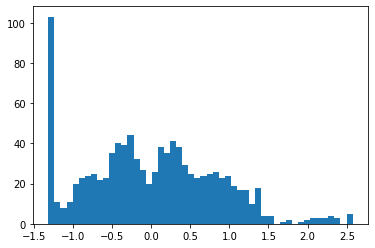

In [55]:
get2 = K.function([model3.layers[0].input], [model3.layers[4].output])
output1 = get2([x1.reshape(len(x1), dim)])
plt.hist(output1[0], bins=50)
plt.show()

In [56]:
np.where(output1[0]>2)
output1[0][581]

array([2.023698], dtype=float32)

### show standard deviations

In [57]:
get2 = K.function([model3.layers[0].input], [model3.layers[3].output])
output2 = get2([x1.reshape(len(x1), dim)])

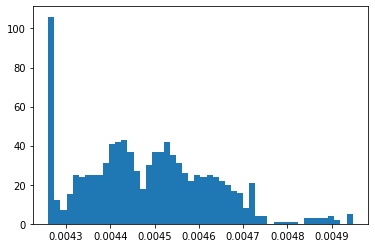

In [58]:
output = np.exp(output2[0])
np.sqrt(np.sum(output*output))
np.sqrt(1/4)
plt.hist(output, bins=50)
plt.show()

In [61]:
sum1=0
for i in range(1000):
    sum1+= 1 - output1[0][i][0]*output1[0][i][0] - output[i][0]*output[i][0] + np.exp(output2[0][i][0])
sum1/1000

0.3028785855874569

In [46]:
len(output1[0]), len(output2[0]), 

(1000, 1000)

In [38]:
# weights after training
W = model3.layers[6].get_weights()
W

[array([[ 5.43675  ,  5.2695036,  5.1052194, ..., -4.959954 , -5.119227 ,
         -5.3239098],
        [ 6.5478325,  6.737101 ,  6.948991 , ..., -6.8016353, -6.5789733,
         -6.4156013]], dtype=float32),
 array([-45.273613, -45.203465, -45.198605, ...,  46.020367,  45.99709 ,
         46.24421 ], dtype=float32)]

In [112]:
b=3
1/(1+np.exp(-b))

0.9525741268224334

In [52]:
plot_results(model3, x1, 100)

NameError: name 'plot_results' is not defined

In [304]:
model3.save_weights('model3')

In [290]:
# simplified dataset
dim = x2.shape[1]*x2.shape[1]
model4 = autoencoder_A2(2, 1)

/home/fabrizio/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_201 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_201.
  'be expecting any data to be passed to {0}.'.format(name))


In [291]:
model4.fit(x2.reshape(len(x2), dim), epochs = 200000)

Epoch 1/200000
4/4 [==============================] - 2s 464ms/step - loss: 1.3663
Epoch 2/200000
4/4 [==============================] - 0s 1ms/step - loss: 1.2744
Epoch 3/200000
4/4 [==============================] - 0s 4ms/step - loss: 1.3336
Epoch 4/200000
4/4 [==============================] - 0s 1ms/step - loss: 1.3126
Epoch 5/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.2828
Epoch 6/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.2355
Epoch 7/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.2337
Epoch 8/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.3021
Epoch 9/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.4156
Epoch 10/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.3290
Epoch 11/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.3452
Epoch 12/200000
4/4 [==============================] - 0s 1ms/step - loss: 1.3611
Epoch 13/200000
4/4 [==

Epoch 101/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.1032
Epoch 102/200000
4/4 [==============================] - 0s 4ms/step - loss: 1.1393
Epoch 103/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.2604
Epoch 104/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.2126
Epoch 105/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0959
Epoch 106/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.1078
Epoch 107/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.0916
Epoch 108/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0757
Epoch 109/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.1180
Epoch 110/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9671
Epoch 111/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.1171
Epoch 112/200000
4/4 [==============================] - 0s 1ms/step - loss: 1.1215
Epoc

Epoch 200/200000
4/4 [==============================] - 0s 3ms/step - loss: 0.9770
Epoch 201/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9473
Epoch 202/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0200
Epoch 203/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9512
Epoch 204/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8607
Epoch 205/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8832
Epoch 206/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9246
Epoch 207/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.1221
Epoch 208/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9233
Epoch 209/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.1194
Epoch 210/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.2043
Epoch 211/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9210
Epoc

Epoch 299/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0217
Epoch 300/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9966
Epoch 301/200000
4/4 [==============================] - 0s 3ms/step - loss: 0.9136
Epoch 302/200000
4/4 [==============================] - 0s 1ms/step - loss: 0.9965
Epoch 303/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0425
Epoch 304/200000
4/4 [==============================] - 0s 1ms/step - loss: 1.0056
Epoch 305/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.3572
Epoch 306/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0582
Epoch 307/200000
4/4 [==============================] - 0s 1ms/step - loss: 0.9277
Epoch 308/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.0306
Epoch 309/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.0178
Epoch 310/200000
4/4 [==============================] - 0s 1ms/step - loss: 1.0522
Epoc

Epoch 398/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8432
Epoch 399/200000
4/4 [==============================] - 0s 1ms/step - loss: 1.0917
Epoch 400/200000
4/4 [==============================] - 0s 1ms/step - loss: 1.1597
Epoch 401/200000
4/4 [==============================] - 0s 1ms/step - loss: 1.0336
Epoch 402/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9815
Epoch 403/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8547
Epoch 404/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0202
Epoch 405/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0243
Epoch 406/200000
4/4 [==============================] - 0s 4ms/step - loss: 0.9996
Epoch 407/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0158
Epoch 408/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8998
Epoch 409/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9042
Epoc

Epoch 497/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8408
Epoch 498/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0223
Epoch 499/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.0410
Epoch 500/200000
4/4 [==============================] - 0s 3ms/step - loss: 0.9898
Epoch 501/200000
4/4 [==============================] - 0s 3ms/step - loss: 0.8912
Epoch 502/200000
4/4 [==============================] - 0s 3ms/step - loss: 0.8266
Epoch 503/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.0960
Epoch 504/200000
4/4 [==============================] - 0s 3ms/step - loss: 0.9019
Epoch 505/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.1454
Epoch 506/200000
4/4 [==============================] - 0s 1ms/step - loss: 1.0982
Epoch 507/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.1172
Epoch 508/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8185
Epoc

Epoch 596/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0329
Epoch 597/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0570
Epoch 598/200000
4/4 [==============================] - 0s 3ms/step - loss: 0.9018
Epoch 599/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8896
Epoch 600/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9231
Epoch 601/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9565
Epoch 602/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9424
Epoch 603/200000
4/4 [==============================] - 0s 1ms/step - loss: 0.7953
Epoch 604/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9901
Epoch 605/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0118
Epoch 606/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9659
Epoch 607/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8249
Epoc

Epoch 695/200000
4/4 [==============================] - 0s 1ms/step - loss: 0.8402
Epoch 696/200000
4/4 [==============================] - 0s 3ms/step - loss: 0.9905
Epoch 697/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0681
Epoch 698/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8110
Epoch 699/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.1759
Epoch 700/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0445
Epoch 701/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8100
Epoch 702/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8034
Epoch 703/200000
4/4 [==============================] - 0s 3ms/step - loss: 0.8941
Epoch 704/200000
4/4 [==============================] - 0s 1ms/step - loss: 1.0401
Epoch 705/200000
4/4 [==============================] - 0s 1ms/step - loss: 0.9610
Epoch 706/200000
4/4 [==============================] - 0s 1ms/step - loss: 0.8795
Epoc

Epoch 794/200000
4/4 [==============================] - 0s 4ms/step - loss: 0.9687
Epoch 795/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8824
Epoch 796/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8541
Epoch 797/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0383
Epoch 798/200000
4/4 [==============================] - 0s 1ms/step - loss: 0.8380
Epoch 799/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9983
Epoch 800/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8019
Epoch 801/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.1217
Epoch 802/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9840
Epoch 803/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9966
Epoch 804/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0192
Epoch 805/200000
4/4 [==============================] - 0s 1ms/step - loss: 0.9048
Epoc

Epoch 893/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0224
Epoch 894/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0462
Epoch 895/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9664
Epoch 896/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.0090
Epoch 897/200000
4/4 [==============================] - 0s 4ms/step - loss: 0.8660
Epoch 898/200000
4/4 [==============================] - 0s 4ms/step - loss: 1.0519
Epoch 899/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0383
Epoch 900/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0407
Epoch 901/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0311
Epoch 902/200000
4/4 [==============================] - 0s 1ms/step - loss: 0.9955
Epoch 903/200000
4/4 [==============================] - 0s 4ms/step - loss: 1.0375
Epoch 904/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0920
Epoc

Epoch 992/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0308
Epoch 993/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9177
Epoch 994/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9197
Epoch 995/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9389
Epoch 996/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0287
Epoch 997/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.1868
Epoch 998/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9328
Epoch 999/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0274
Epoch 1000/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0204
Epoch 1001/200000
4/4 [==============================] - 0s 1ms/step - loss: 1.1680
Epoch 1002/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9667
Epoch 1003/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0601


Epoch 1090/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9779
Epoch 1091/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.1187
Epoch 1092/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.2253
Epoch 1093/200000
4/4 [==============================] - 0s 4ms/step - loss: 0.9094
Epoch 1094/200000
4/4 [==============================] - 0s 4ms/step - loss: 1.0148
Epoch 1095/200000
4/4 [==============================] - 0s 1ms/step - loss: 0.9780
Epoch 1096/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.0176
Epoch 1097/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0634
Epoch 1098/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0034
Epoch 1099/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.0033
Epoch 1100/200000
4/4 [==============================] - 0s 4ms/step - loss: 0.8290
Epoch 1101/200000
4/4 [==============================] - 0s 4ms/step - loss:

Epoch 1188/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.0007
Epoch 1189/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0267
Epoch 1190/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.0073
Epoch 1191/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0125
Epoch 1192/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0013
Epoch 1193/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8682
Epoch 1194/200000
4/4 [==============================] - 0s 1ms/step - loss: 1.0902
Epoch 1195/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8898
Epoch 1196/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.1497
Epoch 1197/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.0638
Epoch 1198/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.0987
Epoch 1199/200000
4/4 [==============================] - 0s 2ms/step - loss:

Epoch 1286/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8245
Epoch 1287/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0276
Epoch 1288/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0344
Epoch 1289/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0594
Epoch 1290/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8260
Epoch 1291/200000
4/4 [==============================] - 0s 3ms/step - loss: 0.8969
Epoch 1292/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0873
Epoch 1293/200000
4/4 [==============================] - 0s 3ms/step - loss: 0.7654
Epoch 1294/200000
4/4 [==============================] - 0s 3ms/step - loss: 0.9916
Epoch 1295/200000
4/4 [==============================] - 0s 1ms/step - loss: 1.0108
Epoch 1296/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9134
Epoch 1297/200000
4/4 [==============================] - 0s 2ms/step - loss:

Epoch 1384/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8447
Epoch 1385/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.1663
Epoch 1386/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9625
Epoch 1387/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.1213
Epoch 1388/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9054
Epoch 1389/200000
4/4 [==============================] - 0s 4ms/step - loss: 1.0690
Epoch 1390/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0602
Epoch 1391/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.0740
Epoch 1392/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9833
Epoch 1393/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0143
Epoch 1394/200000
4/4 [==============================] - 0s 1ms/step - loss: 0.9050
Epoch 1395/200000
4/4 [==============================] - 0s 2ms/step - loss:

Epoch 1482/200000
4/4 [==============================] - 0s 3ms/step - loss: 0.9325
Epoch 1483/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.0081
Epoch 1484/200000
4/4 [==============================] - 0s 4ms/step - loss: 1.0686
Epoch 1485/200000
4/4 [==============================] - 0s 7ms/step - loss: 0.9817
Epoch 1486/200000
4/4 [==============================] - 0s 5ms/step - loss: 1.0362
Epoch 1487/200000
4/4 [==============================] - 0s 5ms/step - loss: 0.8139
Epoch 1488/200000
4/4 [==============================] - 0s 5ms/step - loss: 0.9396
Epoch 1489/200000
4/4 [==============================] - 0s 5ms/step - loss: 0.7823
Epoch 1490/200000
4/4 [==============================] - 0s 4ms/step - loss: 0.8714
Epoch 1491/200000
4/4 [==============================] - 0s 3ms/step - loss: 0.9253
Epoch 1492/200000
4/4 [==============================] - 0s 4ms/step - loss: 1.0288
Epoch 1493/200000
4/4 [==============================] - 0s 3ms/step - loss:

Epoch 1580/200000
4/4 [==============================] - 0s 3ms/step - loss: 0.9743
Epoch 1581/200000
4/4 [==============================] - 0s 1ms/step - loss: 0.8380
Epoch 1582/200000
4/4 [==============================] - 0s 1ms/step - loss: 0.9663
Epoch 1583/200000
4/4 [==============================] - 0s 1ms/step - loss: 0.8723
Epoch 1584/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0783
Epoch 1585/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.0932
Epoch 1586/200000
4/4 [==============================] - 0s 1ms/step - loss: 1.2548
Epoch 1587/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8974
Epoch 1588/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9566
Epoch 1589/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9359
Epoch 1590/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9730
Epoch 1591/200000
4/4 [==============================] - 0s 3ms/step - loss:

Epoch 1678/200000
4/4 [==============================] - 0s 5ms/step - loss: 0.8172
Epoch 1679/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0047
Epoch 1680/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0122
Epoch 1681/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0458
Epoch 1682/200000
4/4 [==============================] - 0s 1ms/step - loss: 0.8158
Epoch 1683/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0487
Epoch 1684/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9919
Epoch 1685/200000
4/4 [==============================] - 0s 3ms/step - loss: 0.8772
Epoch 1686/200000
4/4 [==============================] - 0s 1ms/step - loss: 1.0922
Epoch 1687/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0160
Epoch 1688/200000
4/4 [==============================] - 0s 3ms/step - loss: 0.9542
Epoch 1689/200000
4/4 [==============================] - 0s 2ms/step - loss:

Epoch 1776/200000
4/4 [==============================] - 0s 4ms/step - loss: 1.1169
Epoch 1777/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0747
Epoch 1778/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.1374
Epoch 1779/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9237
Epoch 1780/200000
4/4 [==============================] - 0s 3ms/step - loss: 0.9668
Epoch 1781/200000
4/4 [==============================] - 0s 3ms/step - loss: 1.0047
Epoch 1782/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.1232
Epoch 1783/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9292
Epoch 1784/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0157
Epoch 1785/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8634
Epoch 1786/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9622
Epoch 1787/200000
4/4 [==============================] - 0s 5ms/step - loss:

Epoch 1874/200000
4/4 [==============================] - 0s 3ms/step - loss: 0.9427
Epoch 1875/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9712
Epoch 1876/200000
4/4 [==============================] - 0s 4ms/step - loss: 0.9093
Epoch 1877/200000
4/4 [==============================] - 0s 5ms/step - loss: 0.9017
Epoch 1878/200000
4/4 [==============================] - 0s 4ms/step - loss: 1.0090
Epoch 1879/200000
4/4 [==============================] - 0s 3ms/step - loss: 0.9984
Epoch 1880/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0184
Epoch 1881/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.8443
Epoch 1882/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9907
Epoch 1883/200000
4/4 [==============================] - 0s 2ms/step - loss: 0.9353
Epoch 1884/200000
4/4 [==============================] - 0s 2ms/step - loss: 1.0098
Epoch 1885/200000
4/4 [==============================] - 0s 3ms/step - loss:

KeyboardInterrupt: 

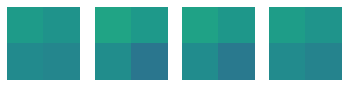

In [292]:
plot_results(model4, x2, 1)

In [278]:
#model4.save_weights('model4.h5')

# 4. Results on mnist

### 1.3 mnist dataset

In [67]:
from keras.datasets import mnist

(x, y), (x_test, y_test) = mnist.load_data()
x = x/255
x3 = x[y==2]
x_test = x[y!=2]
x3.shape, x_test.shape

((5958, 28, 28), (54042, 28, 28))

In [57]:
# A2
dim = x3.shape[1]*x3.shape[1]
model4 = autoencoder_A2(64, 8)

/home/fabrizio/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_43 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_43.
  'be expecting any data to be passed to {0}.'.format(name))


In [58]:
model4.fit(x3.reshape(len(x3), dim), epochs = 200000)

Epoch 1/200000
5958/5958 [==============================] - 1s 192us/step - loss: 72.5808
Epoch 2/200000
5958/5958 [==============================] - 1s 111us/step - loss: 50.6341
Epoch 3/200000
5958/5958 [==============================] - 1s 112us/step - loss: 45.6463
Epoch 4/200000
5958/5958 [==============================] - 1s 117us/step - loss: 40.7628
Epoch 5/200000
5958/5958 [==============================] - 1s 119us/step - loss: 37.0894
Epoch 6/200000
5958/5958 [==============================] - 1s 116us/step - loss: 34.9048
Epoch 7/200000
 768/5958 [==>...........................] - ETA: 0s - loss: 33.9800

KeyboardInterrupt: 

In [69]:
input1  = x3.reshape(-1, 28, 28)
output1 = model4.predict(x3.reshape(len(x3), dim))
mse = mean_squared_error(input1.reshape(-1, 28*28), output1.reshape(-1, 28*28))
mse

0.03621002281167259

In [63]:
def compute_mses(model, x):
    mses = []
    mse = []
    for nr in range(len(x)):
        input1 = x[nr].reshape(28, 28)
        output1 = model.predict(input1.reshape(tuple([1]+ list(model.input_shape[1:])))).reshape(28, 28) # (1, 784) or (1, 28, 28, 1
        mse.append(mean_squared_error(input1.reshape(28*28), output1.reshape(28*28)))
    mses.append(mse)
    return mses

In [64]:
print(len(x), len(x_test))
mses = []
mses.append(compute_mses(model4, x3))
mses.append(compute_mses(model4, x_test))

60000 54042


In [70]:
print(np.mean(mses[0]))
print(np.mean(mses[1]))

0.05585706921343613
0.05799733662872474


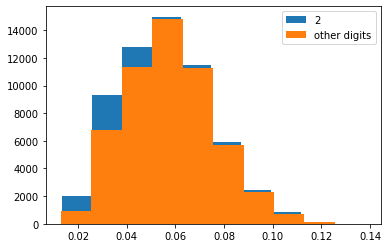

In [72]:
plt.hist(mses[0], label='2')
plt.hist(mses[1], label='other digits')
plt.legend(loc='upper right')
plt.show()

1


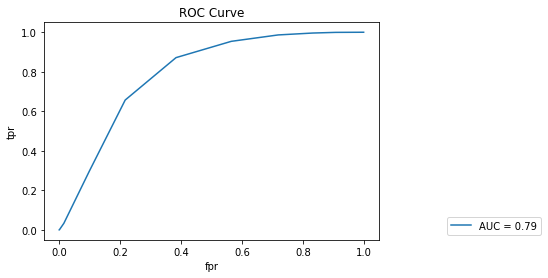

In [343]:
def plot_ROC(mses):
    tpr = []
    fpr = []
    for threshold in np.arange(0,10, 0.01):
        tpr.append(len(np.where(np.array(mses[0])<threshold)[0])/len(mses[0][0]))
        fpr.append(len(np.where(np.array(mses[1])<threshold)[0])/len(mses[1][0]))
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.title("ROC Curve")
    plt.plot(fpr, tpr, label= 'AUC = %0.2f' % (auc(fpr, tpr)))
    plt.legend(loc = 4, bbox_to_anchor=(1.50, 0))
    print(len(mses[0]))
plot_ROC(mses)

### play with bottleneck

In [56]:
# ARTISTIC CREATION
import ipywidgets as widgets
get = K.function([model2.layers[3].input], [model2.layers[4].output])

def widget(x1=1, x2=1, x3=1, x4=1, x5=1, x6=1, x7=1, x8=1):
    input2 = np.array([x1, x2, x3, x4, x5, x6, x7, x8]).reshape(1, 8)
    output = get([input2])
    plt.imshow(output[0].reshape(32, 32))

widgets.interact(widget, 
                 x1=widgets.FloatSlider(min=-1500, max=1500, step=10, value=1220), # 70, 70, 620, -1370
                 x2=widgets.FloatSlider(min=-1500, max=1500, step=10, value=-950))
#                 x3=widgets.FloatSlider(min=-1500, max=1500, step=0.1, value=-0.48), 
#                 x4=widgets.FloatSlider(min=-2500, max=2500, step=0.1, value=-1.8399))
#layer_output = layer_output[0].tolist()
#layer_output = np.round(layer_output, decimals=1)n_model, number)
#plot_ROC(mses, k)

interactive(children=(FloatSlider(value=1220.0, description='x1', max=1500.0, min=-1500.0, step=10.0), FloatSl…

<function __main__.widget(x1=1, x2=1, x3=1, x4=1, x5=1, x6=1, x7=1, x8=1)>

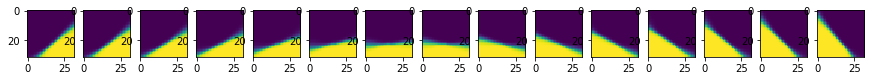

In [253]:
input2 = np.array([100, -0.33, -0.48, -1.48]).reshape(1, 4)
n = 15
f = plt.figure(figsize=(15,5))

for i in range(n):
    plt.subplot(1, n, i+1)
    input2[0,0] = 0.18+i*1.2/n
    input2[0,1] = -0.33+i*-1/n
    input2[0,2] = -0.48+i*-0.3/n
    input2[0,3] = -1.84+i*1.6/n

    output2 = get([input2])[0]
    plt.imshow(output2.reshape(32, 32))
#    plt.imshow(x[603*i].reshape(n, n))
#    plt.subplot(6, 2, i*2+2)
#    plt.imshow(output[600*i].reshape(n, n))
plt.show()

#    input2[0,0] = 183+i*-50/n
#    input2[0,1] = -5+i*-181/n
#    input2[0,2] = -128+i*28/n
#    input2[0,3] = -49+i*50/n

# Filosofia

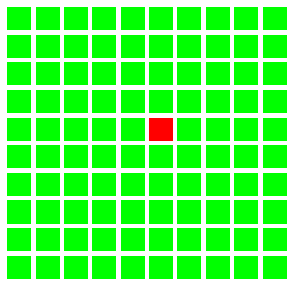

In [3]:
#opinioni
squares = []
squares.append((6, 5))
#squares.append((4, 7))
#squares.append((9, 1))


a = np.zeros((10, 10))
for i in range(len(squares)):
    a[squares[i][0]-1, squares[i][1]-1]=1

b = np.zeros((1, 1, 3))
b[0, 0, 1]=1
f = plt.figure(figsize=(5,5))
for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, i+1+j*10)
        plt.axis('off')
        b[0, 0, 0]=a[i, j]
        if a[i, j]==1:
            b[0, 0, 1]=a[i, j]-1
#        b[0, 0, 2]=(a[i, j]+1)%2
        plt.imshow(b)
        b[0, 0, 1]=1

plt.show()

In [14]:
circles = []
def circle(r):
    img = np.zeros((32, 32))
    theta = np.linspace(0, 2*np.pi, 32)
    x1 = (r*np.cos(theta)).astype(int)+16
    x2 = (r*np.sin(theta)).astype(int)+16
    for i in range(32):
        img[x1[i], x2[i]] = 1
    return img

for i in range(500):
    img = circle(i/50+2)
    circles.append(img)
circles = np.asarray(circles)

def plot_circle(img):
    res = model1.predict(img.reshape(1, 32*32))
    f = plt.figure(figsize=(9,3))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(res.reshape(32, 32))
    plt.show()
#for i in range(10):
#    plot_circle(circles[i])

In [10]:
# 2 degrees of freedom
x = []
dataset_size = 32
l = 32

def create_line(angle, pos):
    x = np.zeros((127, 127))
    center = 127//2
    x[center:].fill(1)
    x = ndimage.rotate(x, angle)
    center2 = x.shape[0]//2
    x = x[center2-l//2+pos:center2+l//2+pos, center2-l//2:center2+l//2]
    return x

for i in range(dataset_size):
    angle = 90*i/dataset_size
    for j in range(32):
        pos = j-16
        x.append(create_line(angle, pos))

x = np.asarray(x)
x.shape

(1024, 32, 32)

In [ ]:
#oppure: 3 degrees of freedom
x = []
l = 32

def create_line(angle, pos, width):
    x = np.zeros((127, 127))
    center = 127//2
    x[center-width-1:center+width].fill(1)
    x = ndimage.rotate(x, angle)
    center2 = x.shape[0]//2
    x = x[center2-l//2+pos:center2+l//2+pos, center2-l//2:center2+l//2]
    return x

for i in range(300):
    print(i)
    angle = 360*i/300
    for j in range(32):
        pos = j-16
        for width in range(4):
            pippo = (create_line(angle, pos, width))
            print(pippo.shape)
            x.append(pippo)
            def autoencoder_02():
    input_img = Input(shape=(dim,))
    encoded = Dense(5, activation='relu')(input_img)
    encoded = Dense(2)(encoded)
    decoded = Dense(5, activation='relu')(encoded)
    decoded = Dense(dim, activation='sigmoid')(decoded)
    model = Model(input_img, decoded)
    model.compile(optimizer='adadelta', loss='binary_crossentropy')
    return model

def autoencoder_03():
    input_img = Input(shape=(dim,))
    encoded = Dense(16, activation='relu')(input_img)
#    encoded = Dense(5, activation='relu')(encoded)
    encoded = Dense(8)(encoded)
#    encoded = Activation('relu')(encoded)
    decoded = Dense(16, activation='relu')(encoded)
#    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(dim, activation='sigmoid')(decoded)
    model = Model(input_img, decoded)
    model.compile(optimizer='adadelta', loss='binary_crossentropy')
    return model

def autoencoder_031():
    input_img = Input(shape=(32, 32, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    encoded = Dense(4, activation='relu')(x)
    x = Dense(8*4*4)(encoded)
    x = Reshape((4, 4, 8))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(input_img, decoded)
    model.compile(optimizer='adadelta', loss='binary_crossentropy')
    return model

def autoencoder_04():
    a = Input(shape=(60,60,1))
    x = (Conv2D(16, (3, 3), activation='relu', padding='same'))(a)
    x = (MaxPooling2D((2, 2), padding='same'))(x)
    x = (Conv2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = (MaxPooling2D((2, 2), padding='same'))(x)
    x = (Conv2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = (MaxPooling2D((3, 3), padding='same'))(x)    
    x = Flatten()(x)
    x = Dense(8)(x)
    x = Dense(8*5*5)(x)
    x = Reshape((5, 5, 8))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = (UpSampling2D((3, 3)))(x)
    x = (Conv2D(8, (3, 3), activation='relu', padding='same'))(x)    
    x = (UpSampling2D((2, 2)))(x)
    x = (Conv2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = (UpSampling2D((2, 2)))(x)
    output = (Conv2D(1, (3, 3), activation='sigmoid', padding='same'))(x)
    model = Model(inputs=a, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adadelta')
    return model
